### About this Notebook

The goal of this notebook is to develop a Convolutional Neural Network (CNN) designed to classify image inputs into their corresponding skin lesion diagnoses. We are using a dataset that includes 10 different types of skin lesions: nevus, basal cell carcinoma, melanoma, vascular lesion, seborrheic keratosis, actinic keratosis, squamous cell carcinoma, dermatofibroma, solar lentigo, and lichenoid keratosis. Given the diversity of classes, we will implement subgrouping to get a more robust performaning model. This model won't exactly be for diagnosis but rather screening, it will all us to correctly identify and prioritize conditions based on their potential harm and required intervention, essentially enhancing overall diagnostic accuracy and utility.  

Throughout the training process, we will employ techniques such as early stopping, callbacks, and learning rate scheduling to optimize results. Extensive testing through trial and error will help us select the most effective architecture, optimizers, hyperparameters, etc.  

Finally, we will train two versions of the model—one with data augmentation and one without—and evaluate the performance of each. The results of these two versions will then be compared to assess their effectiveness.  

### Importing packages

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import random
from PIL import Image
import matplotlib.pyplot as plt
# import pytorch relevant
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
# import tools for evaluation
from sklearn.metrics import classification_report, accuracy_score
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import seaborn as sns

import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting seed for reproducibility
random.seed(42)

# Training on GPU if available as it will allow the model to train faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("Device available for running: " + str(device))

Device available for running: cuda


### Importing Dataset & Check metadata

In [4]:
metadata = pd.read_csv("Project 2/metadata.csv") # read metadata

In [5]:
metadata.head(5)

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,patient_id,personal_hx_mm,sex
0,ISIC_0079358,Hospital Italiano de Buenos Aires,CC-BY,35.0,anterior torso,benign,False,contact polarized,nevus,NaN,False,II,dermoscopic,IL_3989348,IP_9328831,False,female
1,ISIC_0086914,Hospital Italiano de Buenos Aires,CC-BY,55.0,upper extremity,malignant,True,contact polarized,basal cell carcinoma,histopathology,False,II,dermoscopic,IL_9767756,IP_7506563,True,male
2,ISIC_0088904,Hospital Italiano de Buenos Aires,CC-BY,50.0,NaN,malignant,True,contact polarized,basal cell carcinoma,histopathology,False,II,dermoscopic,IL_8711401,IP_0222733,False,female
3,ISIC_0094098,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,True,NaN,melanoma,histopathology,False,II,clinical: overview,IL_6961144,IP_1218261,True,male
4,ISIC_0095134,Hospital Italiano de Buenos Aires,CC-BY,70.0,anterior torso,malignant,True,contact polarized,melanoma,histopathology,False,I,dermoscopic,IL_4530268,IP_8235588,True,female


We will be training a CNN model using the Pytorch Library to classify skin lesion images using the "Hospital Italiano de Buenos Aires - Skin Lesions Images (2019-2022)" from the ISIC Archive.  

***Dataset Reference***  
*Ricci Lara, M.A., Rodríguez Kowalczuk, M.V., Lisa Eliceche, M. et al. A dataset of skin lesion images collected in Argentina for the evaluation of AI tools in this population. Sci Data 10, 712 (2023). https://doi.org/10.1038/s41597-023-02630-0*

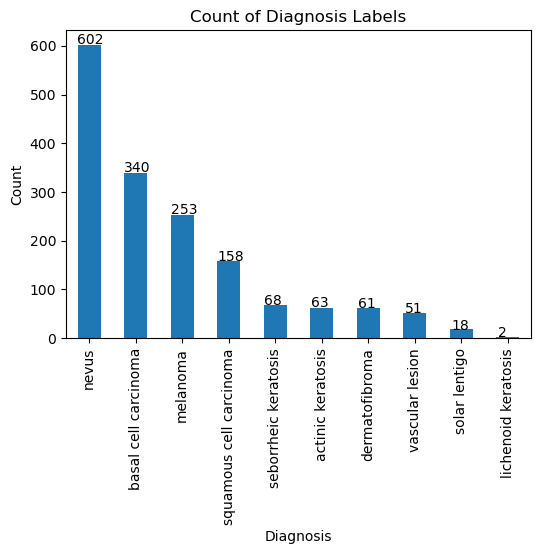

In [6]:
# Counting the number of images for each diagnosis
plt.figure(figsize=(6,4))
ax = metadata['diagnosis'].value_counts().plot(kind='bar')
plt.title('Count of Diagnosis Labels')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

As we can see the dataset comprises of 10 types of skin lesions (classes). This distribution shows significant imbalance among classes, which can adversely affect model performance. Models trained on unbalanced data tend to be biased towards classes with a higher number of instances (In our case Nevus, Basal Cell Carcinoma & Melanoma), potentially leading to poor generalization on under-represented classes.

To mitigate the effects of this imbalance and to enhance clinical relevance, we will be grouping the classes as follows:
1. **Melanocytic Lesions**: Nevus, Melanoma
   - **Justification**: Critical for distinguishing benign moles from malignant melanoma, which is essential for early cancer detection.

2. **Non-Melanoma Skin Cancers**: Basal Cell Carcinoma, Squamous Cell Carcinoma
   - **Justification**: These are the most common types of skin cancer and often treated similarly, making them logical to group together for diagnostic purposes.

3. **Keratinocyte Proliferation Disorders**: Actinic Keratosis, Seborrheic Keratosis, Solar Lentigo, Lichenoid Keratosis
   - **Justification**: Groups lesions primarily caused by abnormal keratinocyte activities, which are generally benign but can be mistaken for more severe conditions.

4. **Fibrous and Vascular Lesions**: Dermatofibroma, Vascular Lesion
   - **Justification**: Focuses on benign fibrous and vascular growths, distinct from more urgent malignant lesions but important for cosmetic and symptomatic treatments.

Grouping these classes into four broader categories will help the model in several ways:
- **Reduces Class Imbalance**: By combining classes into broader categories, we mitigate the issue of class imbalance, improving the model's ability to learn from a more evenly distributed dataset.
- **Enhances Model Generalization**: A model trained on more balanced groups is likely to generalize better on new, unseen data, reducing the risk of overfitting on dominant classes.
- **Increases Clinical Utility**: By categorizing lesions into these four groups, the model helps clinicians prioritize treatment decisions and differentiate between conditions that may appear similar but differ significantly in terms of severity and management.

***References***  
- *Caccavale, S., Calabrese, G., Mattiello, E., Broganelli, P., Ramondetta, A., Pieretti, G., Alfano, R., & Argenziano, G. (2021). Cutaneous Melanoma Arising in Congenital Melanocytic Nevus: A Retrospective Observational Study. Dermatology (Basel, Switzerland), 237(3), 473–478. https://doi.org/10.1159/000510221*
- *Bidari Zerehpoosh, F., Nasiri, S., Zahedifard, S., & Sabeti, S. (2017). Comparison of P53 Intensity, Frequency and Size in Normal Skin Periphery of Squamous Cell Carcinoma, Basal Cell Carcinoma And Melanocytic Nevus in Persian Skin Type. Iranian journal of pathology, 12(1), 62–66.*
- *Ginat, D.T., Cipriani, N.A., Eassa, J., & Petronic-Rosic, V.M. (2018). Benign Cysts, Tumors, and Tumor-Like Non-vascular Lesions of the Skin and Subcutaneous Tissues. Neuroradiological Imaging of Skin Diseases and Related Conditions.*
- *Najeeb, M.A., & Alariyibi, A. (2024). Imbalanced Dataset Effect on CNN-Based Classifier Performance for Face Recognition. International Journal of Artificial Intelligence & Applications.*

### Data selection

In [7]:
# Categorising the diagnosis into 4 categories
MelanocyticLesions = ['melanoma', 'nevus']
NonMelanomaSkinCancers = ['basal cell carcinoma', 'squamous cell carcinoma']
KeratinocyteProliferationDisorders = ['actinic keratosis', 'seborrheic keratosis', 'solar lentigo', 'lichenoid keratosis']
FibrousandVascularLesions = ['dermatofibroma', 'vascular lesion']

# Adding a new column to the metadata dataframe to categorise the diagnosis
metadata['Category'] = metadata['diagnosis'].apply(lambda x: 'Melanocytic Lesions' if x in MelanocyticLesions else ('Non-Melanoma Skin Cancers' if x in NonMelanomaSkinCancers else ('Keratinocyte Proliferation Disorders' if x in KeratinocyteProliferationDisorders else 'Fibrous and Vascular Lesions')))

# Removing all columns except the isic_id, patient_id, diagnosis and Category
meta_selected = metadata[['isic_id', 'patient_id', 'diagnosis', 'Category']]

meta_selected.head(5)

,isic_id,patient_id,diagnosis,Category
0,ISIC_0079358,IP_9328831,nevus,Melanocytic Lesions
1,ISIC_0086914,IP_7506563,basal cell carcinoma,Non-Melanoma Skin Cancers
2,ISIC_0088904,IP_0222733,basal cell carcinoma,Non-Melanoma Skin Cancers
3,ISIC_0094098,IP_1218261,melanoma,Melanocytic Lesions
4,ISIC_0095134,IP_8235588,melanoma,Melanocytic Lesions


In [8]:
# Checking for missing values
if meta_selected.isnull().sum().sum() == 0:
    print("No missing values in the metadata")
else:
    print("Missing values in the metadata")

No missing values in the metadata


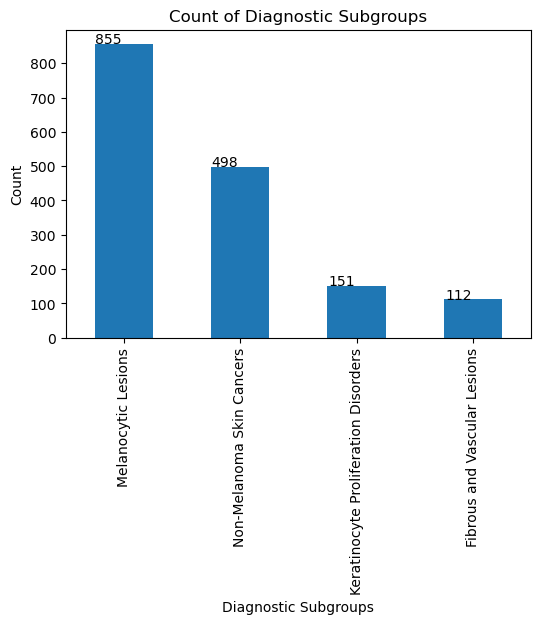

In [9]:
# Checking the distribution of the categories (Diagnostic Subgroups)
plt.figure(figsize=(6,4))
ax = meta_selected['Category'].value_counts().plot(kind='bar')
plt.title('Count of Diagnostic Subgroups')
plt.xlabel('Diagnostic Subgroups')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [10]:
patients = meta_selected['patient_id'].to_numpy()
patients = list(set(patients))
patients.sort()
print("Total number of patients:", len(patients))

Total number of patients: 623


In [11]:
# Checking if there are patients with multiple diagnosis
if len(meta_selected['patient_id']) != len(set(meta_selected['patient_id'])):
    print("Note: There are patients with multiple diagnosis")
else:
    print("There are no patients with multiple diagnosis")

Note: There are patients with multiple diagnosis


### Train-test split

When splitting the data into training and testing subsets, we will ensure that each patient's data is contained entirely within one of these subsets. This is important for preventing data leakage, as some patients have multiple images associated with them. By organizing the data in this manner, we guarantee that a patient's images are not split across both the training and testing datasets. This method helps maintain the integrity of our model during the evaluation process.

In [12]:
# Create a DataFrame to determine the predominant category for each patient
predominant_category = meta_selected.groupby(['patient_id', 'Category']).size().unstack(fill_value=0)
predominant_category['Predominant_Category'] = predominant_category.idxmax(axis=1)

# Now, create a simple DataFrame for stratification purposes
patients_categories = predominant_category[['Predominant_Category']].reset_index()

# Perform a stratified split to separate training and remaining data (test + validation)
train_ids, remaining_ids = train_test_split(patients_categories['patient_id'], test_size=0.30, random_state=42, stratify=patients_categories['Predominant_Category'])

# Further split the remaining data into test and validation sets
test_ids, val_ids = train_test_split(remaining_ids, test_size=0.50, random_state=42, stratify=patients_categories[patients_categories['patient_id'].isin(remaining_ids)]['Predominant_Category'])

# Create the actual train, validation, and test datasets
patients_train = meta_selected[meta_selected['patient_id'].isin(train_ids)]
patients_val = meta_selected[meta_selected['patient_id'].isin(val_ids)]
patients_test = meta_selected[meta_selected['patient_id'].isin(test_ids)]

print("Number of images in the training set:", len(patients_train))
print("Number of images in the validation set:", len(patients_val))
print("Number of images in the testing set:", len(patients_test))

Number of images in the training set: 1197
Number of images in the validation set: 230
Number of images in the testing set: 189


Using a stratified split is particularly beneficial for datasets with class imbalance, like ours. This approach ensures that each class is represented in both the training and testing sets in the same proportions as they appear in the full dataset. By maintaining this balance, the stratified split prevents the model from being biased towards the majority class and improves its ability to generalize to new data. It also allows us to properly test the models perfomance.

### Load the Images & Encoding labels

In [13]:
# This function will allows us to encode the labels (classes) by mapping categories to one-hot encoded vectors
def label_encoder(label):
    mapping = {
        "Melanocytic Lesions": [1, 0, 0, 0],
        "Non-Melanoma Skin Cancers": [0, 1, 0, 0],
        "Fibrous and Vascular Lesions": [0, 0, 1, 0],
        "Keratinocyte Proliferation Disorders": [0, 0, 0, 1]
    }
    return mapping.get(label)  # Returns [0, 0, 0, 0] if label not found

# Function to decode one-hot vectors back to labels
def label_decoder(vector):
    reverse_mapping = {
        (1, 0, 0, 0): "Melanocytic Lesions",
        (0, 1, 0, 0): "Non-Melanoma Skin Cancers",
        (0, 0, 1, 0): "Fibrous and Vascular Lesions",
        (0, 0, 0, 1): "Keratinocyte Proliferation Disorders"
    }
    return reverse_mapping.get(tuple(vector))

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

# Processing the dataset. We are reading the images and their corresponding labels and storing them in the respective numpy arrays.
def process_dataset(patients_data, X_list, y_list):
    for patient_id in patients_data['patient_id'].unique():  # Iterate over unique patient IDs
        patient_data = patients_data[patients_data['patient_id'] == patient_id]
        filenames = patient_data['isic_id'].to_numpy()
        for fname in filenames:
            with Image.open("Project 2/dataset/" + fname + ".JPG") as img:
                img_resized = img.resize((224, 224), Image.Resampling.LANCZOS)  # Resize image to 224x224 pixels
                img_array = np.asarray(img_resized) / 255.0  # Normalize pixel values to [0, 1]
                X_list.append(np.moveaxis(img_array, -1, 0))  # Move channel axis to the correct position
            label = patient_data[patient_data['isic_id'] == fname]['Category'].to_numpy()[0]
            y_list.append(label_encoder(label))  # Convert label to an encoded value

# Process training, validation, and testing datasets
process_dataset(patients_train, X_train, y_train)
process_dataset(patients_val, X_val, y_val)
process_dataset(patients_test, X_test, y_test)

print("Number of images in the training set:", len(X_train))
print("Number of images in the validation set:", len(X_val))
print("Number of images in the testing set:", len(X_test))

Number of images in the training set: 1197
Number of images in the validation set: 230
Number of images in the testing set: 189


In [15]:
X_train, y_train = np.array(X_train).astype('float32'), np.array(y_train).astype('float32')
X_val, y_val = np.array(X_val).astype('float32'), np.array(y_val).astype('float32')
X_test, y_test = np.array(X_test).astype('float32'), np.array(y_test).astype('float32')

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (1197, 3, 224, 224) (1197, 4)
Validation set: (230, 3, 224, 224) (230, 4)
Testing set: (189, 3, 224, 224) (189, 4)


Encoding the categorical labels into one-hot vectors and to processing the images by resizing and normalizing them. The prepared image data and their corresponding labels are stored in arrays which facilitate the development of a CNN model aimed at classifying different types of skin lesions subgroups. Other then the standard train and test set we also have validation set, this will help us during training to implement  early stopping.

### Data Visualization

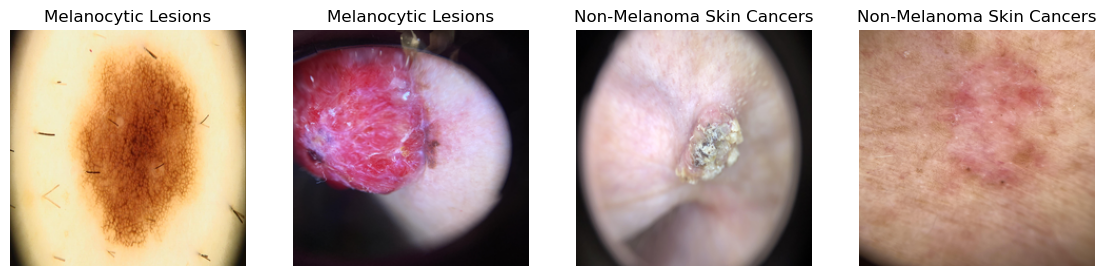

In [16]:
# Plotting 3 random images from the training set and their corresponding labels
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
random_indices = random.sample(range(len(X_train)), 4)  # Get 3 random unique images
for i, idx in enumerate(random_indices):
    axes[i].imshow(np.moveaxis(X_train[idx], 0, -1))
    axes[i].set_title(label_decoder(y_train[idx]))
    axes[i].axis('off')

plt.show()

### Constructing the Model

In [17]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class CNN(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(CNN, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

This AI model architecture is inspired by ResNet-152 and adapted for specific use cases with modifications. It employs a modularized approach using the "Bottleneck" blocks, designed to enhance the network's depth and capability without a substantial increase in computational complexity. Each Bottleneck block consists of three convolutional layers: the first and third layers are 1x1 convolutions responsible for reducing and then increasing dimensions, respectively, without altering the spatial size. The middle layer is a 3x3 convolution that performs the main feature extraction while keeping the computational cost low, thanks to the reduced dimension from the first layer. These layers are interleaved with batch normalization and ReLU activation for stabilization and non-linearity.

The main network, defined in the "CNN" class, initializes with a standard 7x7 convolution followed by batch normalization, ReLU activation, and max pooling to reduce spatial dimensions while capturing essential features. It then constructs four layers of Bottleneck blocks with varying numbers of blocks and channels, increasing the feature abstraction level and the field of view of the network progressively. Strides in later layers are adjusted to reduce spatial dimensions and increase the receptive field. The network culminates in an adaptive average pooling layer that squashes the spatial dimensions to 1x1, ensuring that the spatial context is retained no matter the input size. Finally, a fully connected layer maps the derived features to the class scores. This architecture is particularly effective for tasks requiring high-level feature recognition from large input dimensions, making it suitable for complex visual recognition tasks.

***Reference to original ResNet-152 Model (Microsoft)***  
*He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). https://doi.org/10.48550/arXiv.1512.03385*

In [19]:
def one_hot_to_indices(y):
    return np.argmax(y, axis=1)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(one_hot_to_indices(y_train)).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(one_hot_to_indices(y_val)).long())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(one_hot_to_indices(y_test)).long())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = CNN(Bottleneck, [3, 8, 36, 3], num_classes=4).to(device)

In [ ]:
def one_hot_to_indices(y):
    return np.argmax(y, axis=1)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(one_hot_to_indices(y_train)).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(one_hot_to_indices(y_val)).long())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(one_hot_to_indices(y_test)).long())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = CNN(Bottleneck, [3, 8, 36, 3], num_classes=4).to(device)

In [20]:
class_samples = np.sum(y_train, axis=0)
class_weights = compute_class_weight('balanced', classes=np.arange(4), y=np.argmax(y_train, axis=1))
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=np.sqrt(0.1), verbose=False)

To address the class imbalance, we use a weighted cross-entropy loss. Compute the class weights based on the frequency of each class and apply these to the loss function. This will allow us to "penalize the model more for misidentification of minority classes". This is crucial as our dataset has classes which are underrepresented, as it helps improve model fairness and accuracy on these classes. We have the modified CrossEntropyLoss function that incorporates these class weights, used to calculate loss during training.

Additionally we are using ADAM optimizer, but a learning rate scheduler is configured to reduce the learning rate when the validation loss stops improving. This approach helps in fine-tuning the model by taking smaller steps when approaching a minimum, thus preventing overshooting and potentially achieving better convergence.

In [21]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

The EarlyStopping class is a utility for interrupting the training process when the validation loss stops improving. This class helps prevent overfitting and saves computational resources by terminating the training early if the validation loss does not show significant improvement over a specified number of epochs, along that we have a callback system as well. The best model (Lowest Val loss) is saved and used later in the evaluation step.

### Training the Model

We will be training the model with 300 epochs max (as Early Stopping with a patience of 20 epochs has been implemented)

In [22]:
def train_model(epochs = 250, verbose = True):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_accuracy = evaluate_model(val_loader)  # Evaluate on validation set
        scheduler.step(val_loss)

        if verbose:
            print(f'Epoch {epoch}, Loss: {running_loss}, Validation Loss: {val_loss}')

        # Early stopping logic based on validation loss
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

def evaluate_model(loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [23]:
early_stopping = EarlyStopping(patience=20, verbose=True, path='best_model.pth')

train_model(epochs = 300, verbose = False)

Validation loss decreased (inf --> 1.425428).  Saving model ...
Validation loss decreased (1.425428 --> 1.353264).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (1.353264 --> 1.337310).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
Validation loss decreased (1.337310 --> 1.332518).  Saving model ...
Validation loss decreased (1.332518 --> 1.321082).  Saving model ...
Validation loss decreased (1.321082 --> 1.303654).  Saving model ...
Validation loss decreased (1.303654 --> 1.280214).  Saving model ...
Validation loss decreased (1.280214 --> 1.271851).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
Validation loss decreased (1.2718

### Evaluation

In [24]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [25]:
# Classification report
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte Proliferation Disorders']))

                                      precision    recall  f1-score   support

                 Melanocytic Lesions       0.88      0.64      0.74        91
           Non-Melanoma Skin Cancers       0.67      0.57      0.61        60
        Fibrous and Vascular Lesions       0.32      0.86      0.47        14
Keratinocyte Proliferation Disorders       0.54      0.79      0.64        24

                            accuracy                           0.65       189
                           macro avg       0.60      0.71      0.62       189
                        weighted avg       0.73      0.65      0.67       189



The classifier results for skin lesion diagnosis exhibit varying performance across four categories: Melanocytic Lesions, Non-Melanoma Skin Cancers, Fibrous and Vascular Lesions, and Keratinocyte Proliferation Disorders. The evaluation metrics used are precision, recall, and the F1-score, which provide insights into the model's effectiveness in identifying each type of lesion.

1. **Melanocytic Lesions:**
   - **Precision: 0.88** - This high precision indicates that when the model predicts a lesion as melanocytic, it is correct 88% of the time.
   - **Recall: 0.64** - The recall suggests that the model successfully identifies 64% of all actual melanocytic lesions.
   - **F1-score: 0.74** - The F1-score, a balance between precision and recall, is relatively high, reflecting effective identification despite some missed cases.

2. **Non-Melanoma Skin Cancers:**
   - **Precision: 0.67** - The model has moderate precision for non-melanoma skin cancers, where approximately two-thirds of its predictions are accurate.
   - **Recall: 0.57** - The recall indicates that the model captures 57% of all real cases of non-melanoma skin cancers.
   - **F1-score: 0.61** - This score is indicative of a balanced but modest performance in both precision and recall.

3. **Fibrous and Vascular Lesions:**
   - **Precision: 0.32** - This lower precision suggests a high rate of false positives; many lesions classified as fibrous and vascular are not.
   - **Recall: 0.86** - The high recall shows that the model is effective at identifying most of the actual fibrous and vascular lesions presented to it.
   - **F1-score: 0.47** - Despite high recall, the F1-score remains lower due to the low precision, indicating a trade-off between identifying most cases and the accuracy of those identifications.

4. **Keratinocyte Proliferation Disorders:**
   - **Precision: 0.54** - More than half of the predictions for this class are correct, showing an acceptable level of precision.
   - **Recall: 0.79** - A high recall demonstrates the model's strength in capturing a large majority of actual cases of keratinocyte proliferation disorders.
   - **F1-score: 0.64** - This score is moderately high, influenced positively by recall but tempered by precision.

**Overall Model Performance:**
   - **Accuracy: 0.65** - The overall accuracy shows that 65% of all predictions made by the model across all categories are correct.
   - **Macro Average F1-score: 0.62** - This average indicates a fair performance across all classes, considering both frequent and rare conditions.
   - **Weighted Average F1-score: 0.67** - This score, weighted by the number of true instances in each class, suggests that the model performs better on more prevalent conditions.

The results highlight the model's ability to more reliably detect certain conditions like Fibrous and Vascular Lesions (in terms of recall) while struggling with precision in the same category. We will next try to improve the perfomance by performing Data Augmentation. 

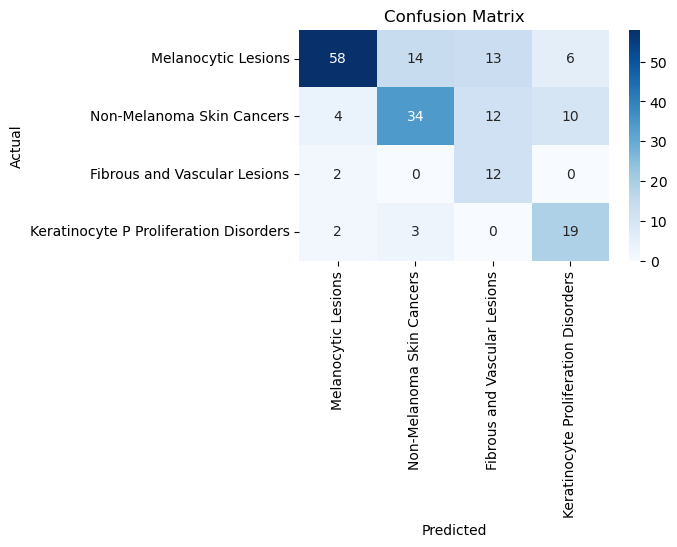

In [34]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte Proliferation Disorders'], yticklabels=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte P Proliferation Disorders'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

The confusion matrix provides a breakdown of the true positives, false positives, false negatives, and true negatives for each class.  
- Melanocytic Lesions: Correctly identified 58 out of 91 cases, with a notable number of these lesions (13) being confused with Fibrous and Vascular Lesions, suggesting some characteristic overlap detected by the model between these classes.
- Non-Melanoma Skin Cancers: Correctly identified 34 out of 60 cases. Misclassification mainly occurs with Keratinocyte Proliferation Disorders (10 cases), indicating possible similarities in features used by the model to identify these conditions.
- Fibrous and Vascular Lesions: This category shows a significant challenge for the model, with all 14 cases being incorrectly classified as - Melanocytic Lesions, which may point to a need for more distinct training examples in this category to improve model distinction.
- Keratinocyte Proliferation Disorders: Correctly identified 19 out of 24 cases. There is some confusion with Non-Melanoma Skin Cancers (3 cases), possibly due to overlapping clinical features.
Overall, the matrix suggests good performance on Melanocytic Lesions and Keratinocyte Proliferation Disorders but indicates a need for improvement in distinguishing Non-Melanoma Skin Cancers and Fibrous and Vascular Lesions.

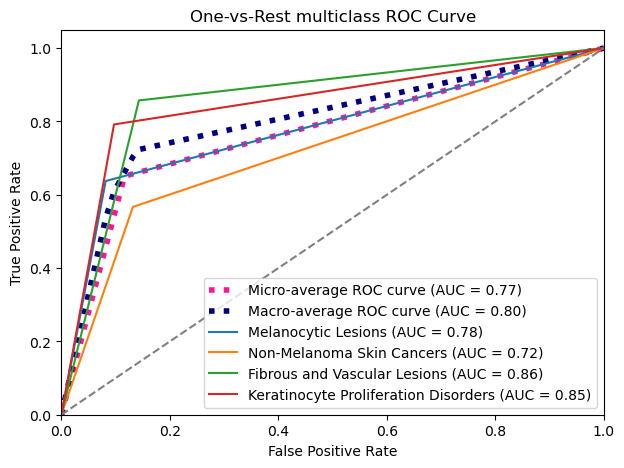

In [33]:
# Plotting one plot for each class (One vs Rest) ROC curve (including micro and macro average)
y_test_onehot = np.eye(4)[y_true]
y_pred_onehot = np.eye(4)[y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7, 5))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

def i_label_decoder(i):
    if i == 0:
        return 'Melanocytic Lesions'
    elif i == 1:
        return 'Non-Melanoma Skin Cancers'
    elif i == 2:
        return 'Fibrous and Vascular Lesions'
    else:
        return 'Keratinocyte Proliferation Disorders'

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{i_label_decoder(i)} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest multiclass ROC Curve')
plt.legend(loc='lower right')

plt.show()

The ROC curve and associated Area Under the Curve (AUC) values provide insight into the model's diagnostic ability across different classification thresholds:

- Micro-average ROC (AUC = 0.77) and Macro-average ROC (AUC = 0.80): These values suggest a good overall performance of the classifier, with the macro-average indicating consistent performance across classes.
- Melanocytic Lesions (AUC = 0.78): Shows decent model performance, though there is room for improvement in distinguishing these lesions more distinctly from others, especially Fibrous and Vascular Lesions.
- Non-Melanoma Skin Cancers (AUC = 0.72): This is the lowest AUC score among the categories, highlighting a need for model refinement in this area, possibly through enhanced feature engineering or more varied training data.
- Fibrous and Vascular Lesions (AUC = 0.86): Despite the high AUC, the complete misclassification in the confusion matrix suggests that while the model can discriminate these lesions at various thresholds, it consistently fails at the chosen operational point.
-Keratinocyte Proliferation Disorders (AUC = 0.85): Indicates strong discriminative power, corroborating the confusion matrix's findings of relatively few misclassifications.

The model exhibits good performance in identifying Fibrous and Vascular Lesions and Keratinocyte Proliferation Disorders, with great specificity and AUC values. However, we can improveme in distinguishing between Melanocytic Lesions and Non-Melanoma Skin Cancers, as evidenced by lower precision, recall, and AUC values for these classes. Misclassifications between Non-Melanoma Skin Cancers and Fibrous and Vascular Lesions suggest possible feature overlap or inadequate model training on distinctive features. Performing data augmentation can possible relove this issue. Let us continue and see in the next section.

### Data Augmentation

We are essentially going to repeat the above procedure but this time around we will introduce data augmentation into the training set. Data augmentation will allows us to generate new training samples by applying transformations to the original data. This effectively expands the dataset, allowing the CNN to learn from a more diverse set of examples. By exposing the CNN to a wider range of variations in the data, it helps the model generalize better to unseen examples. It reduces overfitting and improved feature extraction capabilities. Overall increasing the perfomance of our model.

In [59]:
from torchvision.transforms import v2 # Importing the vision library for transforms (Data Augmentation)
from torchvision.transforms import GaussianBlur

In [60]:
img = torch.tensor(X_train[0])  # Get the first image from the training set
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5), # Horizontal flip
    v2.RandomVerticalFlip(p=0.5), # Vertical flip
    v2.RandomRotation(degrees=20), # Rotation
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02), 
    v2.GaussianBlur(kernel_size=3, sigma=(0.5, 1)), # Added Gaussian Blur to simulate slight focus variations
    v2.Lambda(lambda x: x + 0.01*torch.randn_like(x))  # Added Gaussian Noise
])

We will be performing various random transformations including Resizing, Flipping, Rotation, Color Manuplation & introdcuing some Gaussian Blur.

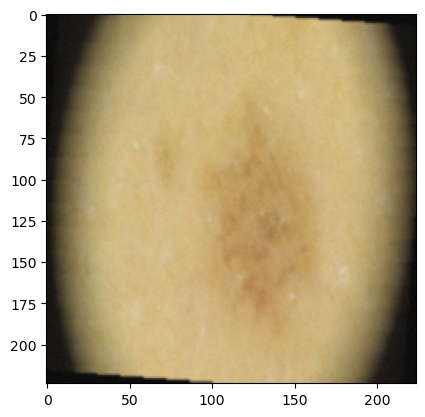

In [61]:
img = transforms(img)
plt.imshow(np.moveaxis(img.numpy(), 0, -1))
plt.show()

In [62]:
X_train_augmented = []
y_train_augmented = []

# Performing Data Augmentation on minority class. We are augmenting the images in the training set to balance the classes. Only Augmenting the images in the minority class to match the majority class.
def augment_dataset(X, y, category, target_count):
    category_indices = np.where(np.argmax(y, axis=1) == category)[0]
    category_images = X[category_indices].copy()  # Make a copy to work with
    category_labels = y[category_indices].copy()

    augmented_images = []
    augmented_labels = []

    while len(augmented_images) < target_count - len(category_images):
        for img, label in zip(category_images, category_labels):
            img_tensor = torch.tensor(img, dtype=torch.float32)
            img_augmented = transforms(img_tensor)
            img_augmented = img_augmented.numpy()
            augmented_images.append(img_augmented)
            augmented_labels.append(label)
            if len(augmented_images) + len(category_images) >= target_count:
                break

    # Append original and augmented images and labels to the training sets
    X_train_augmented.extend(category_images.tolist() + augmented_images)
    y_train_augmented.extend(category_labels.tolist() + augmented_labels)

    print(f"Category {category} augmentation completed. Total images: {len(X_train_augmented)}")

# Calculate the target count for each category
target_count = int(np.max(class_samples))
for category in range(4):
    augment_dataset(X_train, y_train, category, target_count)

X_train_augmented = np.array(X_train_augmented).astype('float32')
y_train_augmented = np.array(y_train_augmented).astype('float32')

print("Number of images in the augmented training set:", len(X_train_augmented))

Category 0 augmentation completed. Total images: 855
Category 1 augmentation completed. Total images: 1710
Category 2 augmentation completed. Total images: 2565
Category 3 augmentation completed. Total images: 3420
Number of images in the augmented training set: 3420


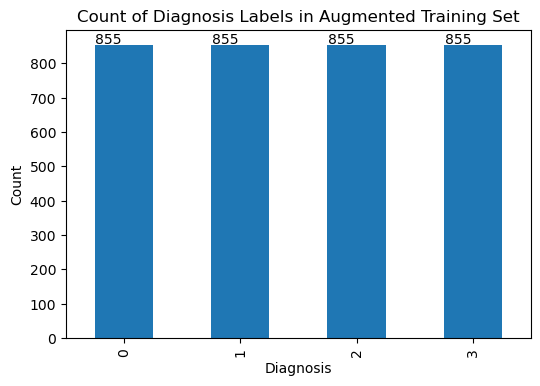

In [63]:
# Plot the count of each category in the augmented training set
plt.figure(figsize=(6,4))
ax = pd.Series(one_hot_to_indices(y_train_augmented)).value_counts().plot(kind='bar')
plt.title('Count of Diagnosis Labels in Augmented Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

We performed data augmentation transformations on the minority classes so that all 4 classes are now balanced.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


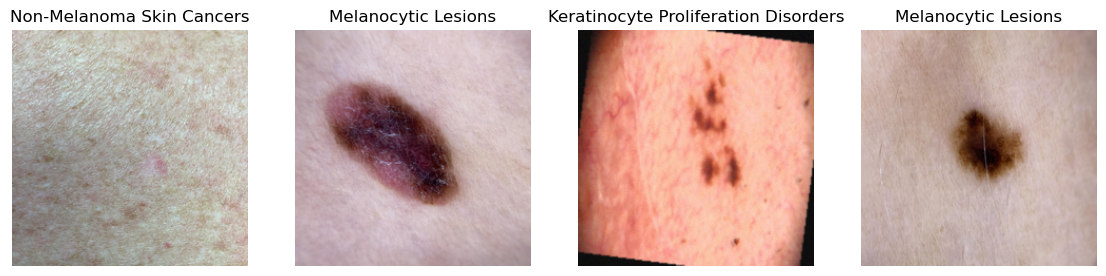

In [64]:
# Plotting 3 random images from the augmented training set and their corresponding labels
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
random_indices = random.sample(range(len(X_train_augmented)), 4)  # Get 4 random unique images

for i, idx in enumerate(random_indices):
    img = np.transpose(X_train_augmented[idx], (1, 2, 0))  # Reorder dimensions to (height, width, channels)
    axes[i].imshow(img)
    axes[i].set_title(label_decoder(y_train_augmented[idx]))  # Assume 'label_decoder' function exists to get label names
    axes[i].axis('off')

plt.show()

Training The Model (With Augmented Data)

In [74]:
model = CNN(Bottleneck, [3, 8, 36, 3], num_classes=4).to(device)

train_dataset = TensorDataset(torch.from_numpy(X_train_augmented).float(), torch.from_numpy(one_hot_to_indices(y_train_augmented)).long())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=np.sqrt(0.1), verbose=False)

early_stopping = EarlyStopping(patience=25, verbose=True, path='best_model_augmented.pth')
train_model(epochs = 300, verbose = False)

Validation loss decreased (inf --> 1.578734).  Saving model ...
Validation loss decreased (1.578734 --> 1.443547).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (1.443547 --> 1.434957).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping counter: 20 out of 20
Early stopping


In [65]:
model.load_state_dict(torch.load('best_model_augmented.pth'))

<All keys matched successfully>

In [66]:
# Classification report
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte Proliferation Disorders']))

                                      precision    recall  f1-score   support

                 Melanocytic Lesions       0.99      0.82      0.90        91
           Non-Melanoma Skin Cancers       0.82      0.97      0.89        60
        Fibrous and Vascular Lesions       0.74      1.00      0.85        14
Keratinocyte Proliferation Disorders       0.96      0.92      0.94        24

                            accuracy                           0.89       189
                           macro avg       0.87      0.93      0.89       189
                        weighted avg       0.91      0.89      0.90       189



The performance metrics of our Skin Lesion Classifier have drastically improved after data augmentation, as demonstrated in the results table. The classifier was evaluated using precision, recall, and f1-score metrics along with the support (number of samples) for each category like before.
- Melanocytic Lesions:
    - Precision (0.99): The model is highly precise in predicting Melanocytic Lesions, indicating that 99% of the predictions made for this class were correct.  
    - Recall (0.82): The recall rate suggests that the model successfully identifies 82% of all actual cases of Melanocytic Lesions, which is robust but indicates room for improvement in sensitivity.  
    - F1-Score (0.90): The high F1-score is indicative of a strong balance between precision and recall.
- Non-Melanoma Skin Cancers:  
    - Precision (0.82): This indicates that 82% of the lesions classified as Non-Melanoma were indeed correct, showcasing good precision.  
    - Recall (0.97): A very high recall suggests that the model is excellent at detecting almost all actual cases of Non-Melanoma Skin Cancers.  
    - F1-Score (0.89): Reflects the effective balance of precision and recall in this class.  
- Fibrous and Vascular Lesions:  
    - Precision (0.74): Lower precision compared to other categories, indicating more false positives within this class.  
    - Recall (1.00): Indicates perfect identification of all actual Fibrous and Vascular Lesions, showcasing the model’s strength in sensitivity for this class.  
    - F1-Score (0.85): Despite the lower precision, the F1-score is bolstered by perfect recall.  
- Keratinocyte Proliferation Disorders:  
    - Precision (0.96): Indicates high accuracy in predictions, with 96% of predicted Keratinocyte Disorders being correct.  
    - Recall (0.92): Very high, ensuring that 92% of actual cases are detected.  
    - F1-Score (0.94): This high score indicates an excellent balance between precision and recall, making it one of the most reliably predicted classes.  

Overall Performance:
- Accuracy (0.89): Shows that the model correctly predicts the class labels for 89% of the total dataset.
- Macro Average (0.87 Precision, 0.93 Recall, 0.89 F1-Score): These averages across classes suggest that while precision varies among classes, recall rates are generally high, leading to a high overall F1-Score.
- Weighted Average (0.91 Precision, 0.89 Recall, 0.90 F1-Score): Weighted metrics, which consider the support for each class, indicate a strong performance across heavily supported classes, contributing positively to overall precision and F1-score.  

The results highlight the model’s efficacy and reliability in classifying skin lesions with a commendable balance of precision and recall, particularly in life-critical categories such as Melanocytic and Non-Melanoma Skin Cancers. The slightly lower precision in the Fibrous and Vascular Lesions class suggests a potential area for model refinement.

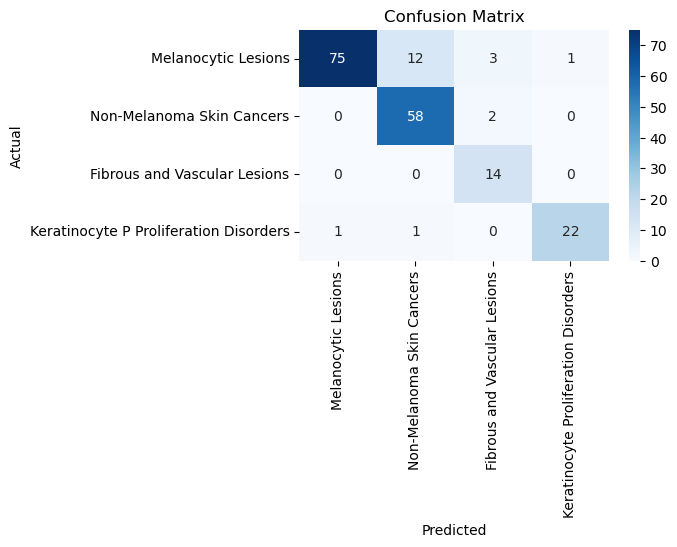

In [54]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte Proliferation Disorders'], yticklabels=['Melanocytic Lesions', 'Non-Melanoma Skin Cancers', 'Fibrous and Vascular Lesions', 'Keratinocyte P Proliferation Disorders'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

The confusion matrix offer more detailed insights into the performance of the multi-class skin lesion classifier across the four categories.

- Melanocytic Lesions: Most accurately predicted with 75 true positives. However, there are 12 cases misclassified as Non-Melanoma Skin Cancers, and a few misclassifications into other categories, indicating a potential area for improving specificity.
- Non-Melanoma Skin Cancers: Exhibits excellent predictive accuracy with 58 true positives and only 2 cases misclassified as Melanocytic Lesions, showcasing the model's strong performance for this crucial category.
- Fibrous and Vascular Lesions: Perfectly classified with 14 true positives and no misclassifications, demonstrating the model's exceptional specificity and sensitivity for this category.
- Keratinocyte Proliferation Disorders: Also shows strong performance with 22 true positives, though there is a slight confusion with Melanocytic Lesions and Non-Melanoma Skin Cancers.

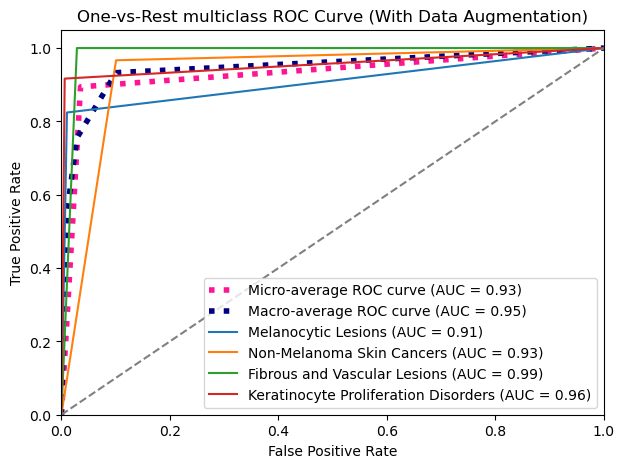

In [56]:
# Plotting one plot for each class (One vs Rest) ROC curve (including micro and macro average)
y_test_onehot = np.eye(4)[y_true]
y_pred_onehot = np.eye(4)[y_pred]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7, 5))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

def i_label_decoder(i):
    if i == 0:
        return 'Melanocytic Lesions'
    elif i == 1:
        return 'Non-Melanoma Skin Cancers'
    elif i == 2:
        return 'Fibrous and Vascular Lesions'
    else:
        return 'Keratinocyte Proliferation Disorders'

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{i_label_decoder(i)} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest multiclass ROC Curve (With Data Augmentation)')
plt.legend(loc='lower right')

plt.show()

- Micro-Average ROC Curve (AUC = 0.93): Indicates overall excellent model performance in distinguishing between classes on an individual case basis across all instances.
- Macro-Average ROC Curve (AUC = 0.95): This higher average suggests that the model performs very well across the different classes uniformly, without being skewed by class imbalance.  
  
- Melanocytic Lesions (AUC = 0.91) and Non-Melanoma Skin Cancers (AUC = 0.93): These are slightly lower but still indicate a high ability of the model to differentiate these conditions from others.
- Fibrous and Vascular Lesions (AUC = 0.99) and Keratinocyte Proliferation Disorders (AUC = 0.96): Very high AUC values reflect the model's outstanding performance in accurately and consistently identifying these conditions.

### Comparing results with and without Data Augmentation

**Report on Multiclass Skin Lesion Classifier: Comparison of Results with and without Data Augmentation**

1. Without Data Augmentation:
The classifier without data augmentation showed decent performance with an overall accuracy of 65% and a weighted average F1-score of 0.67. However, the precision and recall varied significantly among different lesion categories:
- Melanocytic Lesions had a strong precision but moderate recall, resulting in an F1-score of 0.74.
- Non-Melanoma Skin Cancers presented modest metrics across the board with an F1-score of 0.61.
- Fibrous and Vascular Lesions demonstrated high recall but very low precision, leading to an F1-score of 0.47.
- Keratinocyte Proliferation Disorders showed balanced metrics with an F1-score of 0.64.  

2. With Data Augmentation:
Data augmentation significantly improved the classifier's performance, increasing the overall accuracy to 89% and the weighted average F1-score to 0.90. Each category showed improved metrics:  
- Melanocytic Lesions saw substantial improvements in precision and recall, reaching an F1-score of 0.90.
- Non-Melanoma Skin Cancers benefited greatly in terms of recall and achieved an F1-score of 0.89.
- Fibrous and Vascular Lesions achieved perfect recall and a much-improved precision, resulting in an F1-score of 0.85.
- Keratinocyte Proliferation Disorders maintained high precision and recall, with an F1-score of 0.94.  

Overall Comparison:  
Data augmentation played a crucial role in enhancing the model's precision and recall, significantly boosting its overall performance. The improvements are particularly noticeable in the Non-Melanoma Skin Cancers and Fibrous and Vascular Lesions categories (2 out of the 3 minority classes which were increased in number by data augmentation), where the challenges of low precision and recall were effectively addressed. The macro and micro-average ROC values also increased, indicating a stronger ability of the model to discriminate between the classes at various decision thresholds.

Conclusion:  
The introduction of data augmentation of minority classes led to an across-the-board enhancement in the classifier's ability to accurately and reliably diagnose different types of skin lesions. While precision in some classes like Fibrous and Vascular Lesions could still use refinement, the overall improvements suggest a robust model capable of effective clinical application, especially in critical categories such as Melanocytic and Non-Melanoma Skin Cancers. Further adjustments and targeted data augmentation could potentially optimize the model's performance in the less precise categories.

### Self-Reflection on the Skin Lesion Classifier Project

Throughout this project, I have acquired a lot of knowledge (and patience), and have come to understand that building a classification model involves a lot of trial and error. I spent countless hours tweaking various aspects of the model—experimenting with different architectures, criteria, optimizers, learning rates, batch sizes, and other hyperparameters in an effort to increase the overall performance.  

I also learnt a few new thinfs like learning rate schedulers, which proved to be quite useful. The hands-on experience gained from applying these concepts was invaluable, deepening my understanding of CNNs.  

I am quite pleased with the final performance of the model, especially its proficiency in classifying the more critical and potentially life-threatening Melanocytic lesions. However, I recognize that the model requires further refinement and extensive testing across various datasets and environments before it can be deployed in a clinical setting.  

Looking ahead, I have several ideas to further improve the model's performance. These include employing techniques such as squeeze and excitation to refine feature extraction and considering an increase in the model's complexity (Although that might lead to overfitting and may need to counter that by implementing regulization and/or dropout techniques).  

Overall, this project has been a rewarding journey that improved my technical skills and knowledge about CNNs and techniques to get the most out of a model.  